# Extraction de features


## Import des données

In [1]:
#import des bibliothèques requises
import pandas as pd
import numpy as np

On charge désormais la base de données dans un dataframe avant de la visualiser.

In [2]:
#On importe le jeu de données
data = pd.read_csv('database_clean.csv')
#On affiche sa taille et les noms des colonnes
print(data.shape)
print(data.columns)
#On affiche les premières lignes pour mieux comprendre les données
data.head()

(27128, 3)
Index(['Tags', 'Texte', 'Texte_clean'], dtype='object')


,Tags,Texte,Texte_clean
0,<javascript><geolocation><projection><processi...,Mercator longitude and latitude calculations t...,mercator longitude latitude calculation map uk...
1,<c++><file-format><autocad><cad><solid-bodies>,Starting point for learning CAD/CAE file forma...,point cad cae file stress analysis software un...
2,<c#><.net><linq><datatable><.net-3.5>,LINQ query on a DataTable I'm trying to perfor...,linq query datatable linq query object query e...
3,<c++><performance><optimization><stl><c++-faq>,How to overload std::swap() is used by many st...,overload stdswap container assignment implemen...
4,<c><file><directory><cross-platform><common-ta...,How do you get a directory listing in C? How d...,directory scan directory folder file cross pla...


## Split Train/Test

Avant d'extraire des features de nos documents, nous allons séparer notre base de données en deux jeux : l'un pour l'entraînement des modèles, l'autre pour leur évaluation. Il faudra ne prendre en compte que le premier pour les différentes transformations de nos variables.

In [3]:
import random

random.seed(0)
#On isolera 20% de la database pour le jeu de test
proportion_test = 0.2
N = data.shape[0]

#On sépare la database en 2
test_index = random.sample(data.index.tolist(), int(N*proportion_test))
data_test = data.loc[test_index]
data_train = data.drop(index = test_index)

#On vérifie la taille des deux jeux de données obtenus
print(data_test.shape)
print(data_train.shape)

(5425, 3)
(21703, 3)


## Traitement des tags

Les tags devront être manipulés dans les approches supervisées, mais ils risquent d'être trop nombreux pour que les modèles marchent efficacement. Nous allons voir combien ils sont, avant de ne conserver que les plus fréquents.

In [4]:
import re

#Cette fonction transformera la chaîne de tags entre chevrons en une liste de tags
def formatage_tags(tags):
    temp = re.findall(r'<[^>]+>', tags)
    return [mot[1:-1] for mot in temp]

#Cette fonction transforme une liste de tags en une chaîne de tags entre chevrons, en filtrant les tags autorisés
def compression_tags(liste_tags, tags_autorises):
    temp = []
    for tag in liste_tags:
        if tag in tags_autorises:
            temp.append(tag)
    #On pense à mettre un tag "NONE" au cas où aucun des tags d'un texte ne serait autorisé
    if temp == []:
        return '<NONE>'
    else :
        return '<'+'><'.join(temp)+'>'

In [5]:
import operator

#On commence par tranformer les tags en une liste
data_train['liste_tags'] = data_train['Tags'].apply(formatage_tags)

#On va compter le nombre d'apparitions de chaque tag et les stocker dans un dictionnaire
dict_tags = {}
for liste in data_train['liste_tags']:
    for mot in liste:
        #On incrémente le nombre d'occurences, qui est considéré par la fonction "get" comme étant 0
        #si le mot n'est pas encore présent dans le dictionnaire
        dict_tags[mot] = dict_tags.get(mot, 0) + 1
        
#On affiche les tags triés par nombre d'occurences, avant d'isoler les 100 plus fréquents
sorted_tags = sorted(dict_tags.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_tags)
dict_tags = dict(sorted_tags[:100])

[('java', 2460), ('python', 2430), ('javascript', 2151), ('c#', 2112), ('ios', 1901), ('android', 1580), ('c++', 1473), ('.net', 1133), ('iphone', 1021), ('objective-c', 1018), ('html', 942), ('jquery', 775), ('php', 753), ('c', 747), ('linux', 655), ('css', 581), ('node.js', 546), ('performance', 519), ('sql', 507), ('xcode', 504), ('swift', 493), ('asp.net', 471), ('spring', 453), ('windows', 396), ('multithreading', 395), ('algorithm', 392), ('mysql', 392), ('asp.net-mvc', 391), ('cocoa-touch', 386), ('ruby-on-rails', 382), ('string', 364), ('json', 364), ('database', 361), ('arrays', 344), ('macos', 330), ('git', 319), ('sql-server', 299), ('c++11', 295), ('django', 284), ('ruby', 283), ('bash', 282), ('pandas', 281), ('wpf', 272), ('image', 268), ('numpy', 262), ('ajax', 253), ('unit-testing', 249), ('r', 248), ('python-3.x', 241), ('shell', 231), ('security', 229), ('hibernate', 225), ('visual-studio', 224), ('rest', 223), ('http', 212), ('jpa', 211), ('angularjs', 209), ('gcc', 

In [6]:
#On remets en forme les tags en ne conservant que les 100 tags les plus fréquents dans le jeu de train
data_train['Tags'] = data_train['liste_tags'].apply(lambda x: compression_tags(x, dict_tags.keys()))
#On supprime la colonne temporaire que nous avions créée
data_train.drop(columns = ['liste_tags'], inplace = True)
data_train.head()

,Tags,Texte,Texte_clean
0,<javascript>,Mercator longitude and latitude calculations t...,mercator longitude latitude calculation map uk...
1,<c++>,Starting point for learning CAD/CAE file forma...,point cad cae file stress analysis software un...
3,<c++><performance><optimization>,How to overload std::swap() is used by many st...,overload stdswap container assignment implemen...
5,<c#><.net>,Returning DataTables in WCF/.NET I have a WCF ...,datatables wcf wcf service return know topic d...
6,<c#><.net><performance><datetime>,Is DateTime.Now the best way to measure a func...,way measure function performance bottleneck me...


In [7]:
#Evidemment on n'oublie pas de faire la même transformation sur le jeu de test
data_test['Tags'] = data_test['Tags'].apply(formatage_tags).apply(lambda x: compression_tags(x, dict_tags.keys()))

Afin d'extraire des variables numériques de nos textes, il va falloir les vectoriser.

## Bag of Words & TF-IDF

L'approche **Bag of Words** consiste à décrire un texte par le nombre de fois qu'apparaissent chaque mot d'un vocabulaire donné. L'approche **TF-IDF** est très semblable (raison pour laquelle nous allons traiter ces deux vectorisations simultanément) sauf qu'elle pondère les occurences de chaque mot dans un document par la rareté de ce mot dans le corpus tout entier.

### Vectorisation

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#On initialise les deux vectorizers
bow_vect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

#On indique quelle colonne contient les phrases a traiter
col_phrases = 'Texte_clean'

#On va supprimer les documents qui n'ont plus de textes à traiter à cause du POS tagging
data_temp = data_train.dropna(axis=0, subset=col_phrases)

#On fit + transform les deux vectorizers au jeu de train
bow_transform = bow_vect.fit_transform(data_temp[col_phrases])  
tf_transform = tf_vect.fit_transform(data_temp[col_phrases])

#On formate les résultats en sparse DataFrame (pour économiser l'espace mémoire)
df_bow_sparse = pd.DataFrame.sparse.from_spmatrix(bow_transform,
                                                  index=data_train.index, columns=bow_vect.get_feature_names_out())
df_tf_sparse = pd.DataFrame.sparse.from_spmatrix(tf_transform,
                                                 index=data_train.index, columns=tf_vect.get_feature_names_out())

In [9]:
#Jetons un oeil aux vectorisations obtenues
print(bow_transform.shape)
print(tf_transform.shape)
df_bow_sparse.head()

(21703, 31368)
(21703, 31368)


,aa,aaa,aaaaa,aaaabnzacyceaaaadaqabaaabaqdfzxxlxojlomptlpfmqyjiacatwatfkwmkmtt,aaand,aaapy,aabb,aac,aacae,aacencoded,...,μop,μäŕςћ,χ²,ωlg,сocoapods,шěđлеśđαỳ,بابل,ứỷờịệ,青春版,ﬂexible
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Mots les plus fréquents

On va commencer par regarder les mots les plus fréquents dans notre corpus, ainsi que ceux qui ont le plus de poids dans notre TF-IDF.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#Petite fonction d'affichage des mots les plus fréquents, empruntée à internet
def word_frequency_barplot(df, nr_top_words=50):
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    
    #Notons que la fonction trie le dataframe !
    df.sort_values(ascending=False, inplace = True)
    sns.barplot(list(range(nr_top_words)), df.values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

D:\Anaconda\envs\IML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\envs\IML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


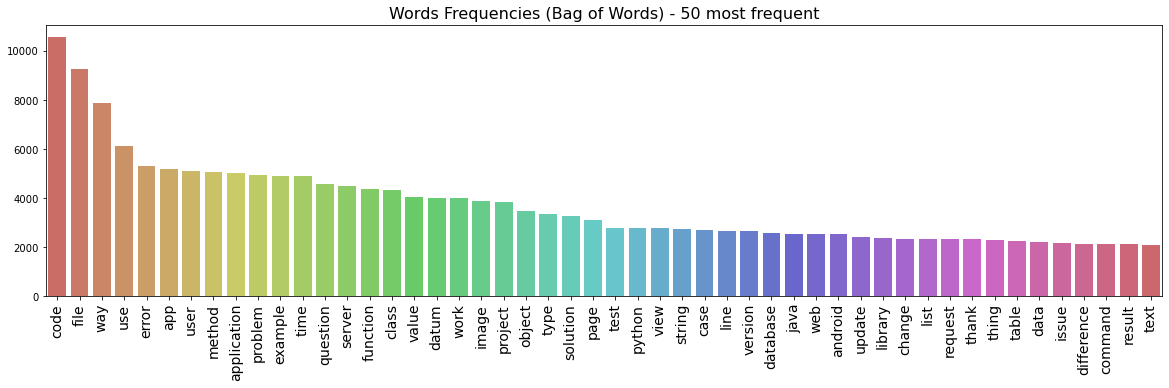

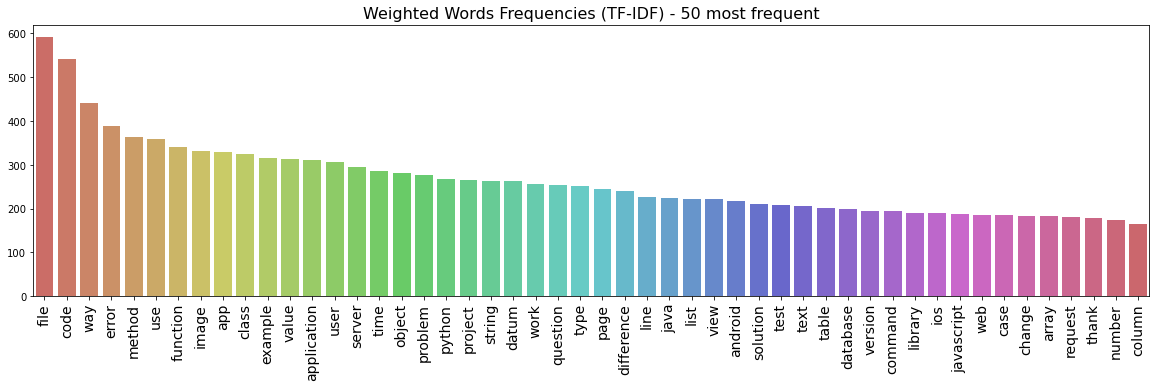

In [11]:
#On va compter les occurences en sommant les apparitions de chaque mot dans TOUS les documents du corpus
count_bow = df_bow_sparse.sum()
count_tf = df_tf_sparse.sum()
#Puis faire appel à notre fonction d'affichage pour représenter le résultat obtenu
ax = word_frequency_barplot(count_bow)
ax.set_title("Words Frequencies (Bag of Words) - 50 most frequent", fontsize=16);
ax = word_frequency_barplot(count_tf)
ax.set_title("Weighted Words Frequencies (TF-IDF) - 50 most frequent", fontsize=16);

On retrouve beaucoup de mots en rapport avec l'informatique (comme "file", "code" ou "server"), ce qui est logique compte tenu de la nature des textes étudiés. Néanmoins les mots enregistrés dans notre vocabulaire sont encore trop nombreux, et certains n'apparaissent que dans un ou deux textes. Nous allons essayer de réduire le nombre de mots (et donc de variables) étudiés.

### Réduction dimensionelle

Nous allons commencer par faire une ACP, afin de voir si on peut isoler quelques variables latentes (qui seraient donc des combinaisons de mots) pertinentes. Cependant il y a trop de variables (plus de 30000) pour que l'ACP puisse se faire correctement. On va tâcher de faire un premier tri en supprimant en amont les mots trop rares.

In [12]:
from sklearn import preprocessing, decomposition
#custom_functions contient des fonctions codées lors de projets précédents, ici pour afficher les résultats de l'ACP
import custom_functions as cf

#On ne conserve que les 10000 mots les plus fréquents dans le jeu de train
trimmed_bow = df_bow_sparse.drop(columns = count_bow.index[10000:])
print(trimmed_bow.shape)

D:\Anaconda\envs\IML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


(21703, 10000)


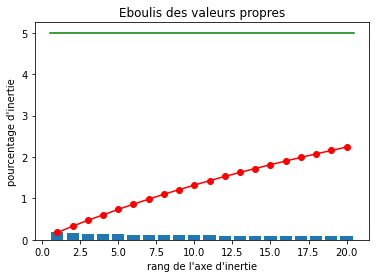

In [13]:
#On lance l'ACP, en générant 20 variables parmi les 10000 restantes
colonnes = trimmed_bow.columns
n_comp = 20
#On restreint notre database aux données qui nous intéressent
data_pca = trimmed_bow
#On prépare les données pour l'ACP
data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns
#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

L'ACP peine à identifier des variables latentes expliquant une grande part de l'inertie des données. On va essayer de l'aider en tronquant davantage les variables.

In [14]:
#On ne conserve que les 1000 mots les plus fréquents dans le jeu de train
trimmed_bow = df_bow_sparse.drop(columns = count_bow.index[1000:])
print(trimmed_bow.shape)

(21703, 1000)


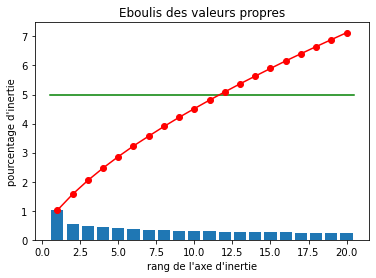

In [15]:
#On recommence l'ACP, cette fois-ci en générant 20 variables parmi les 1000 restantes
colonnes = trimmed_bow.columns
n_comp = 20
#On restreint notre database aux données qui nous intéressent
data_pca = trimmed_bow
#On prépare les données pour l'ACP
data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns
#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

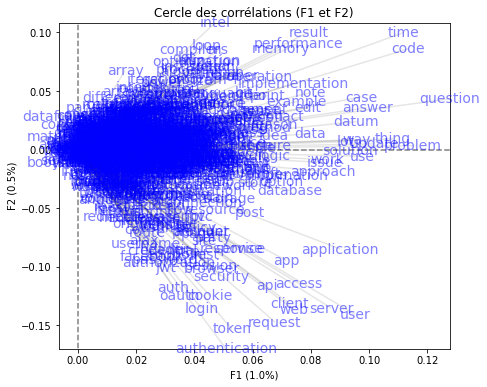

In [16]:
#On va afficher les premiers cercles de corrélations
pcs = pca.components_
cf.ACP_cercles_correlation(pcs, n_comp, pca, [(0,1)], labels = colonnes)

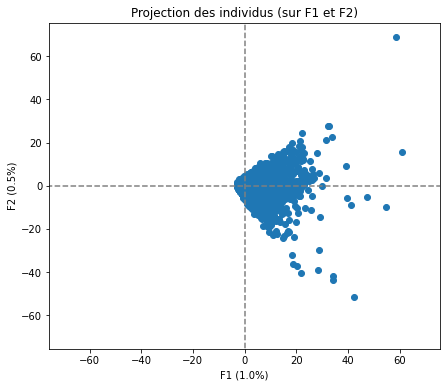

In [17]:
#Projection des individus sur les premiers plans factoriels
X_projected = pca.transform(X_scaled)
cf.ACP_plans_factoriels(X_projected, n_comp, pca, [(0,1)])
plt.show()

Le résultat manque de pertinence, les variables générées par l'ACP n'explique que trop peu l'inertie de nos données. Nous allons néanmoins essayer la même procédure avec la vectorisation TF-IDF.

(21703, 10000)


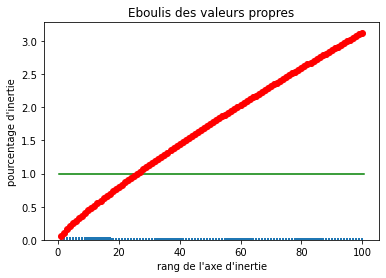

In [18]:
#On ne conserve à nouveau que les 10000 mots les plus influents
trimmed_tf = df_tf_sparse.drop(columns = count_tf.index[10000:])
print(trimmed_tf.shape)
#On va commencer par chercher un maximum de 1000 variables explicatives parmi les 10000 présentes
colonnes = df_tf_sparse.columns
n_comp = 100
#On restreint notre database aux données qui nous intéressent
data_pca = trimmed_tf
#On prépare les données pour l'ACP
data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns
#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

In [19]:
#On ne conserve à nouveau que les 1000 mots les plus influents
trimmed_tf = df_tf_sparse.drop(columns = count_tf.index[1000:])
print(trimmed_tf.shape)

(21703, 1000)


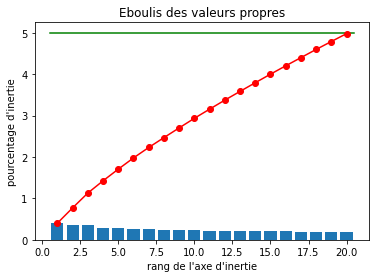

In [20]:
#On recommence l'ACP, cette fois-ci en générant 20 variables parmi les 1000 restantes
colonnes = trimmed_tf.columns
n_comp = 20
#On restreint notre database aux données qui nous intéressent
data_pca = trimmed_tf
#On prépare les données pour l'ACP
data_pca = data_pca.fillna(0)
X = data_pca.values
features = data_pca.columns
#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

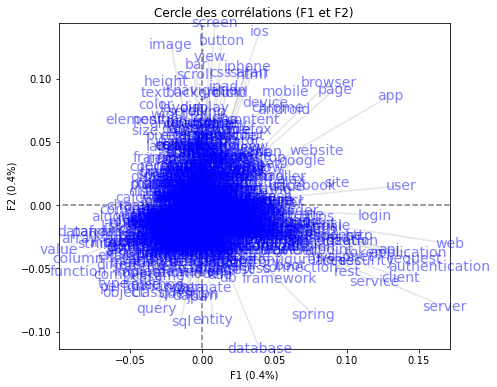

In [21]:
#On va afficher les cercles de corrélations
pcs = pca.components_
cf.ACP_cercles_correlation(pcs, n_comp, pca, [(0,1)], labels = colonnes)

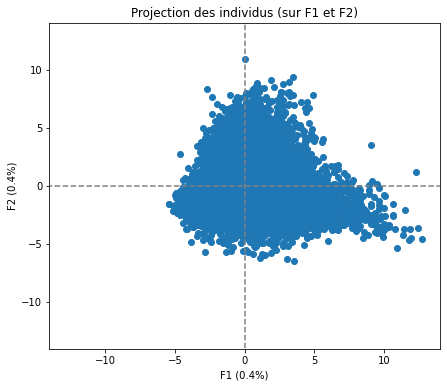

In [22]:
#Projection des individus sur les plans factoriels
X_projected = pca.transform(X_scaled)
cf.ACP_plans_factoriels(X_projected, n_comp, pca, [(0,1)])
plt.show()

Dans les deux cas, l'ACP ne parvient pas à mettre en évidence des variables lattentes pertinentes pour nos traitements. Nous allons donc simplement conserver les 1000 mots les plus fréquents/impactants dans notre Bag of Words et notre TF-IDF, afin d'obtenir un nombre de variables raisonnable.

In [23]:
#On fusionne les vectorisations obtenues avec les données initiales avant de les exporter en .csv
data_bow = data_train.merge(trimmed_bow, how='left', left_index = True, right_index = True)
data_bow.to_csv(path_or_buf='database_bow.csv', index = False)
data_tf = data_train.merge(trimmed_tf, how='left', left_index = True, right_index = True)
data_tf.to_csv(path_or_buf='database_tf.csv', index = False)

Il ne faut pas oublier d'exporter également le jeu de test, après lui avoir fait subir exactement les mêmes transformations : d'abord une vectorisation à l'aide du Bow ou TF-IDF entraîné sur le jeu de train, puis une suppression des mots trop peu fréquents dans le jeu de train, avant de fusionner cela aux données d'évaluation.

In [24]:
#On vectorise le jeu de test
bow_transform_test = bow_vect.transform(data_test.dropna(axis=0, subset=col_phrases)[col_phrases])  
tf_transform_test = tf_vect.transform(data_test.dropna(axis=0, subset=col_phrases)[col_phrases])  
#On convertit en sparse dataframe
df_bow_sparse_test = pd.DataFrame.sparse.from_spmatrix(bow_transform_test,
                                                       index=data_test.index, columns=bow_vect.get_feature_names_out())
df_tf_sparse_test = pd.DataFrame.sparse.from_spmatrix(tf_transform_test,
                                                      index=data_test.index, columns=tf_vect.get_feature_names_out())
#On supprime les colonnes selon le même critère de sélection que le jeu de train
trimmed_bow_test = df_bow_sparse_test.drop(columns = count_bow.index[1000:])
trimmed_tf_test = df_tf_sparse_test.drop(columns = count_tf.index[1000:])
#On fusionne avec le jeu de test avant d'exporter en .csv
data_bow_test = data_test.merge(trimmed_bow_test, how='left', left_index = True, right_index = True)
data_bow_test.to_csv(path_or_buf='database_bow_test.csv', index = False)
data_tf_test = data_test.merge(trimmed_tf_test, how='left', left_index = True, right_index = True)
data_tf_test.to_csv(path_or_buf='database_tf_test.csv', index = False)

## Word embeddings

Les **Word Embeddings** permettent de vectoriser les mots en conservant leur sens sous la forme de propriétés algébriques.

### Word2Vec

Nous allons entraîner notre propre word embedding avec **Word2Vec**, avant de l'utiliser pour vectoriser nos documents. Pour cela il nous faudra tokenizer nos questions, en supprimant la ponctuation.

In [25]:
from gensim.utils import tokenize
from gensim.models import Word2Vec

def tokenizer(texte):
    return list(tokenize(texte, deacc=True, lower=True))

#On précise quelle colonne nous utiliserons
col_phrases = 'Texte'
#On va tokenizer les phrases en listes de mots pour l'apprentissage du modèle
training = [tokenizer(t) for t in data_train[col_phrases]]
#On entraîne un modèle Word2Vec sur nos données
model = Word2Vec(training, min_count = 1, window = 5, sg=0) 

In [26]:
#Ces fonctions permettent de vectoriser un texte à partir de notre embedding de mots
#On somme les vectorisations de chaque mot dans le texte
def text_vectors(texte, model):
    return sum(get_vect(w, model) for w in tokenizer(texte))
#Cette fonction renvoie la vectorisation du mot OU le vecteur nul si le mot est inconnu du modèle
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

In [27]:
#On peut générer nos vectorisations de textes
w2v = data_train[col_phrases].apply(lambda x : text_vectors(x, model))
#On vérifie la forme des résultats
print(w2v.shape)
print(w2v.iloc[0])

(21703,)
[-138.8329      88.62912    104.80051    219.21913     68.27017
  -69.45617    146.17603     83.5324     -67.87142    -12.700084
   23.8382      26.52931    -26.39017     80.03348     -7.580534
   88.87824     50.14999   -109.051      -31.07447    -82.34463
   65.39486    -34.409485   -59.662712    70.839424    41.491016
   45.059628   -27.07012     24.984041   -30.6676     -27.083025
   72.91966     26.471716   -80.09867     -7.6223445   71.64274
   66.91406     37.844116   -70.11464     49.188435   -40.80527
  -35.512226     5.61046    -31.06582    -10.536775     5.836931
  -43.05442   -171.32668     14.463825    74.509605    61.54373
    3.8801749    1.7911037  -53.196472   -25.20269    -72.01196
   15.26979     16.870316    41.572056    -9.958935    81.83088
  -37.859016    33.885178    11.689648   -82.53966   -115.37484
  -29.850117    61.25047     10.700381    13.858567    58.177532
 -131.03368    114.942825    97.3555    -141.82068    -76.02208
   23.256475     2.038928

In [28]:
#On va convertir notre vectorisation en DataFrame
df_w2v = pd.DataFrame(w2v.tolist(), index=data_train.index, columns=range(100))
print(df_w2v.shape)
df_w2v.head()

(21703, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-138.832901,88.629120,104.800507,219.219131,68.270172,-69.456169,146.176025,83.532402,-67.871422,-12.700084,...,-34.180027,22.255054,-7.330420,35.135033,50.402241,-65.186577,124.508316,22.025282,45.335041,-6.254529
1,-98.977417,26.674582,58.217270,85.359077,22.692974,5.029856,104.431549,28.867138,-22.881271,-15.537724,...,-12.433281,19.143091,20.346701,0.176041,21.254330,-47.942818,54.335442,42.198441,3.302508,-17.053118
3,-31.715616,35.387196,17.488804,37.401192,10.505548,1.338587,55.848652,24.639050,-15.121937,-0.207962,...,6.786113,1.331408,9.745511,-1.764036,8.754398,-11.406009,28.010376,7.516707,9.748100,2.699163
5,-190.194595,71.311012,109.853340,195.936264,41.948441,-31.454990,95.404007,109.838364,-22.910126,2.028125,...,8.161910,-7.926886,-3.704511,-5.566916,16.250536,-63.028561,76.476196,81.827080,-7.545650,39.873905
6,-50.068993,21.168261,7.867363,36.719826,18.387157,-4.776515,32.129749,14.502537,-20.421976,5.619939,...,1.150408,-5.017413,-3.831364,3.765001,-1.793223,-4.973561,33.729664,20.360443,4.050070,-7.830570


On peut essayer d'afficher la vectorisation de tous les mots de notre vocabulaire, afin de voir s'il y a des motifs spécifiques qui émergent uniquement à partir du plongement algébrique des mots présents dans notre corpus. Pour cela nous allons faire appel à l'algorithme t-SNE pour avoir un résultat visualisable en 2 dimensions.

In [29]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

import matplotlib.pyplot as plt
import random

#Ces fonctions sont issues d'un tutoriel sur internet
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

#Modifications apportées : selected_indices permet éventuellement de choisir certaines étiquettes à faire apparaître
#(plutôt que de les choisir aléatoirement), et scatter_size permet de régler la taille des points
def plot_with_matplotlib(x_vals, y_vals, labels, scatter_size = 10, selected_indices=[]):

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals, s=scatter_size)

    indices = list(range(len(labels)))
    if selected_indices == []:
        selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]), fontsize='large')

In [30]:
#Cette ligne va récupérer les coordonnées 2D de la réduction des vectorisations de tous les mots de notre vocabulaire
x_vals, y_vals, labels = reduce_dimensions(model)

D:\Anaconda\envs\IML\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\IML\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


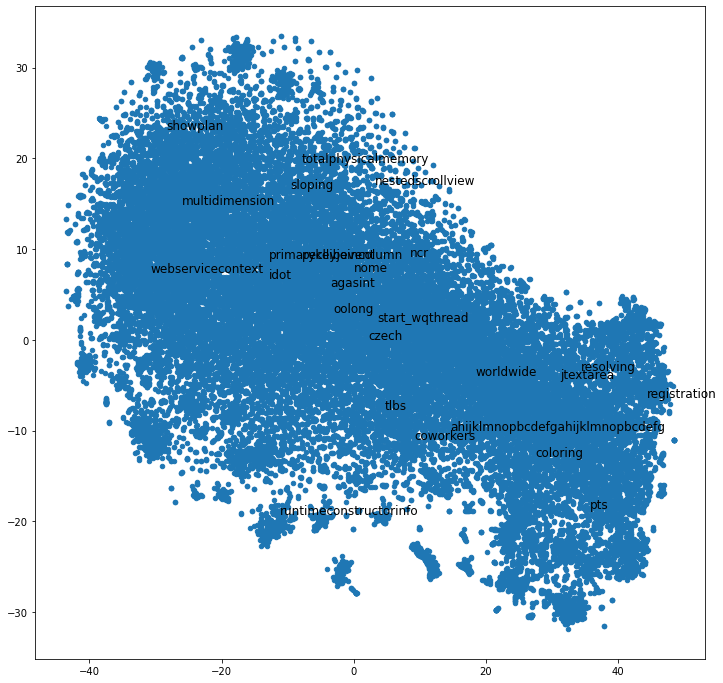

In [31]:
#On affiche le résultat obtenu
points_scale = 20
selected_indices = []
plot_with_matplotlib(x_vals, y_vals, labels, points_scale, selected_indices)

Les mots utilisés dans notre corpus semblent avoir des sens relativement proches, et il ne semble pas y avoir de clusters évidents avec cette représentation.

In [32]:
#On fusionne nos vectorisations avec les données avant d'exporter en .csv
data_w2v = data_train.merge(df_w2v, how='left', left_index = True, right_index = True)
data_w2v.to_csv(path_or_buf='database_w2v.csv', index = False)

Il ne faut pas oublier d'exporter également le jeu de test, après lui avoir fait subir exactement les mêmes transformations : d'abord une vectorisation à l'aide de notre Word2Vec entraîné sur le jeu de train, puis une conversion en DataFrame, avant de fusionner cela aux données d'évaluation.

In [33]:
#On vectorise
w2v_test = data_test[col_phrases].apply(lambda x : text_vectors(x, model))
#On convertit
df_w2v_test = pd.DataFrame(w2v_test.tolist(), index=data_test.index, columns=range(100))
#On fusionne
data_w2v_test = data_test.merge(df_w2v_test, how='left', left_index = True, right_index = True)
#On exporte
data_w2v_test.to_csv(path_or_buf='database_w2v_test.csv', index = False)

### USE

Nous allons utiliser l'algorithme pré-entraîné **Universal Sentence Encoder** de Google, afin de vectoriser nos documents tout en préservant le sens des mots.

In [34]:
import tensorflow_hub as hub

#On importe le modèle pré-entraîné
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#On le teste sur deux phrases quelconques
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])
print(embeddings)

tf.Tensor(
[[-0.03133015 -0.06338634 -0.016075   ... -0.03242779 -0.04575739
   0.05370456]
 [ 0.05080862 -0.01652433  0.01573779 ...  0.00976657  0.0317012
   0.01788119]], shape=(2, 512), dtype=float32)


Le chargement fonctionne bien. Le modèle gère des phrases avec ponstuation, nous allons donc essayer de lui donner les textes en entier. Même s'ils sont parfois composés de plusieurs phrases, le modèle devrait arriver à les gérer correctement. Nous utilisertons la fonction *numpy()* pour formater le *Tensor* obtenu.

In [35]:
#On précise quelle colonne contient les textes à manipuler
col_phrases = "Texte"
use = data_train[col_phrases].apply(lambda x: embed([x]).numpy()[0])
#On vérifie que tout s'est bien passé
print(use.shape)
use.head()

(21703,)


0    [-0.028300427, -0.06643494, -0.05505643, 0.021...
1    [-0.06183865, -0.068042256, 0.01390007, 0.0618...
3    [0.01425172, -0.070463434, 0.043723386, -0.002...
5    [-0.054522593, -0.06529511, 0.06261257, -0.017...
6    [-0.018517146, -0.052888725, -0.037225798, -0....
Name: Texte, dtype: object

In [36]:
#On convertit nos vectorisations en DataFrame
df_use = pd.DataFrame(use.tolist(), index=data_train.index, columns=range(512))
print(df_use.shape)
df_use.head()

(21703, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.028300,-0.066435,-0.055056,0.021637,0.065491,0.041183,-0.059594,0.057816,-0.065294,0.061681,...,0.015944,-0.067285,0.037467,-0.030200,0.055697,0.065050,-0.007969,0.033120,-0.005994,-0.021647
1,-0.061839,-0.068042,0.013900,0.061812,0.033550,-0.024985,-0.059817,0.063830,-0.041058,-0.015499,...,0.025068,-0.065279,0.012942,0.016776,-0.069897,0.066179,0.017820,0.060028,-0.029135,-0.063384
3,0.014252,-0.070463,0.043723,-0.002921,0.039176,0.047006,0.065745,-0.031192,0.005856,0.071593,...,-0.017394,-0.072381,0.029358,-0.070786,0.019498,-0.017685,0.020693,0.073793,-0.004406,0.004228
5,-0.054523,-0.065295,0.062613,-0.017571,0.003668,0.039311,0.055374,-0.064935,0.054970,0.067220,...,0.001709,-0.068075,-0.000101,-0.020418,0.046734,-0.062165,0.043847,0.068074,-0.017898,-0.037102
6,-0.018517,-0.052889,-0.037226,-0.042735,0.037281,-0.037934,-0.057746,-0.004424,0.067991,0.073922,...,0.046747,-0.038951,0.022992,-0.069126,0.063291,-0.013801,0.073607,0.076682,-0.030643,0.031145


In [37]:
#On fusionne nos vectorisations avec les données avant d'exporter en .csv
data_use = data_train.merge(df_use, how='left', left_index = True, right_index = True)
data_use.to_csv(path_or_buf='database_use.csv', index = False)

Il ne faut pas oublier d'exporter également le jeu de test, après lui avoir fait subir exactement les mêmes transformations : d'abord la vectorisation à l'aide de notre USE pré-entraîné, puis une conversion en DataFrame, avant de fusionner cela aux données d'évaluation.

In [38]:
use_test = data_test[col_phrases].apply(lambda x: embed([x]).numpy()[0])
df_use_test = pd.DataFrame(use_test.tolist(), index=data_test.index, columns=range(512))
data_use_test = data_test.merge(df_use_test, how='left', left_index = True, right_index = True)
data_use_test.to_csv(path_or_buf='database_use_test.csv', index = False)

## BERT

On va à nouveau faire du **Transfer Learning**, avec l'algorithme pré-entrainé **Bidirectional Encoder Representations from Transformers**.

In [39]:
from transformers import BertTokenizer, BertModel

#Fonction qui va séparer le document en phrases, avant d'ajouter les indicateurs spécifiques à BERT
def decoupage_phrases_BERT(texte):
    phrases = re.findall(r'[^\.\!\?]*[\.\!\?]', texte)
    return ["[CLS] " + sentence + " [SEP]" for sentence in phrases]

#Fonction qui va tokenizer une phrase (avec un BERT tokenizer, qui va découper certains mots), avant de convertir
#les tokens en nombres reconnus par BERT. On pense à tronquer la phrase si elle est trop longue
def preparation_phrase(phrase, tokenizer, MAX_LEN=512):
    temp = tokenizer.tokenize(phrase)
    ids = [tokenizer.convert_tokens_to_ids(token) for token in temp]
    if len(ids) > 512:
        ids = ids[:512]
    return ids

D:\Anaconda\envs\IML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import torch

#Fonction qui va vectoriser avec BERT une phrase préalablement formatée
def vectorisation_BERT(input_ids, model):
    #On formate les ids reconnus par BERT en un tensor de torch
    tokens_tensor = torch.tensor([input_ids])
    #On génère un masque d'attention, ici ==1 car on n'entre qu'une phrase à la fois
    segments_tensors = torch.tensor([[1] * len(input_ids)])
    #On vient récupérer le résultat
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        #Il faudra paramètrer le modèle avec `output_hidden_states = True`,
        #afin de pouvoir récupérer les états cachés des couches de neurones
        hidden_states = outputs[2]
        # `hidden_states` has shape [13 x 1 x 22 x 768]
    #On va prendre comme vectorisation de la phrase la moyenne des 22 vecteurs de taille 768
    sentence_embedding = torch.mean(hidden_states[-2][0], dim=0)
    #On n'oublie pas de convertir le résultat en array de numpy
    return sentence_embedding.numpy()

#Fonction qui va faire appel aux 3 fonctions précédentes pour transformer un texte en un vecteur de taille 768
def vectorisation_texte(texte, model, tokenizer):
    #On segmente le texte en phrases
    phrases = decoupage_phrases_BERT(texte)
    #On liste les vectorisations de chacune des phrases du texte, après tokenization et formatage
    vecteurs = [vectorisation_BERT(preparation_phrase(phrase, tokenizer), model) for phrase in phrases]
    #On renvoie la moyenne des vectorisations des phrases contenues dans notre texte
    return np.mean(vecteurs, axis=0)

In [41]:
#On prépare le tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#On prépare le modèle pré-entrainé ("from_pretrained"), en précisant "output_hidden_states = True"
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
#Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [42]:
#On précise dans quelle colonne se trouve le texte qui nous intéresse
col_phrases = 'Texte'
#On vient transformer nos textes en vecteurs à l'aide de notre fonction de vectorisation
bert = data_train[col_phrases].apply(lambda x: vectorisation_texte(x, model, tokenizer))
print(bert.shape)

D:\Anaconda\envs\IML\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


(21703,)


In [43]:
#On convertit nos vectorisations en DataFrame
df_bert = bert.apply(lambda x: pd.Series(x))
print(df_bert.shape)
df_bert.head()

(21703, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.077186,0.074752,0.309513,-0.298462,0.185254,-0.089440,-0.300804,0.517501,-0.090341,-0.189600,...,-0.174983,0.082978,-0.168641,-0.224123,0.009866,0.294790,-0.217948,-0.365212,0.202528,0.430936
1,-0.023319,-0.055036,0.088778,-0.098998,0.228116,-0.275144,-0.335567,0.308500,-0.166841,-0.263957,...,-0.230659,0.085963,-0.052265,-0.172333,-0.046513,0.303522,-0.059302,-0.397907,0.086381,0.420312
3,-0.166720,-0.216081,0.041943,0.029787,0.065480,-0.391269,-0.284818,0.293013,0.112014,-0.135579,...,-0.103545,-0.105451,-0.256377,-0.235651,-0.001237,0.561311,0.232275,-0.483032,-0.127365,0.840927
5,-0.029738,-0.190203,0.250462,-0.066955,0.132707,-0.145098,-0.286465,0.525621,-0.140306,-0.072179,...,-0.044747,0.001144,-0.139105,-0.265707,0.065440,0.196937,0.061868,-0.400954,0.199743,0.354941
6,0.000566,-0.235535,0.150236,0.034632,0.431708,-0.183675,0.137913,0.351457,-0.080188,-0.378232,...,-0.253498,-0.021426,-0.054813,-0.309792,0.066410,0.185938,-0.211818,-0.311356,0.166335,0.234478


In [44]:
#On fusionne nos vectorisations avec les données avant d'exporter en .csv
data_bert = data_train.merge(df_bert, how='left', left_index = True, right_index = True)
data_bert.to_csv(path_or_buf='database_bert.csv', index = False)

Il ne faut pas oublier d'exporter également le jeu de test, après lui avoir fait subir exactement les mêmes transformations : d'abord la transformation et vectorisation à l'aide du BERT pré-entrainé, puis une conversion en DataFrame, avant de fusionner cela aux données d'évaluation.

In [45]:
bert_test = data_test[col_phrases].apply(lambda x: vectorisation_texte(x, model, tokenizer))
df_bert_test = bert_test.apply(lambda x: pd.Series(x))
data_bert_test = data_test.merge(df_bert_test, how='left', left_index = True, right_index = True)
data_bert_test.to_csv(path_or_buf='database_bert_test.csv', index = False)

D:\Anaconda\envs\IML\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
